In [1]:
import os.path
import datetime
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.supervised  import SupervisedDataLoader 
from datatools.customtransformers import LogTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV 
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline 
np.set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.4f}'.format
sns.set()
import logging
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logger.setLevel(logging.DEBUG)


03-Feb-19 16:17:14 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown
03-Feb-19 16:17:14 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
load_app_config()
DIRECTORY="AVLoanPrediction"
TRAIN_FILE  = "train.csv"
TEST_FILE  = "test.csv"
RESPONSE = "Loan_Status"
input_path = get_datafolder_path()
train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)
test_file = os.path.join(input_path, DIRECTORY, TEST_FILE)
supervisedloader = SupervisedDataLoader(train_file=train_file,test_file=test_file,response =RESPONSE) 
train_dataset,test_dataset = supervisedloader.load()
supervisedloader.response

03-Feb-19 16:17:14 - INFO - Adding D:\DataSource to system path
03-Feb-19 16:17:14 - INFO - Adding D:\MachineLearning to system path
03-Feb-19 16:17:14 - INFO - Loading train_file :D:\DataSource\AVLoanPrediction\train.csv
03-Feb-19 16:17:14 - INFO - Loading test_file :D:\DataSource\AVLoanPrediction\test.csv


'Loan_Status'

In [3]:
def get_nullframe(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    return pd.DataFrame({'feature':null_sum.index,'count':null_sum.values,
                          'null_percent':(null_sum.values/dataset.shape[0])*100}).sort_values(by=['count'],ascending=False)

In [4]:
train_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0000,nan,360.0000,1.0000,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,"1,508.0000",128.0000,360.0000,1.0000,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0000,66.0000,360.0000,1.0000,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,"2,358.0000",120.0000,360.0000,1.0000,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0000,141.0000,360.0000,1.0000,Urban,Y


In [5]:
train = train_dataset
test = test_dataset

In [6]:
continuous_ds = train.select_dtypes(np.number)
continuous_columns = continuous_ds.columns.values.tolist()
categorical_ds = train.select_dtypes("object")
categorical_columns = categorical_ds.columns.values.tolist()
ordinal_columns =['Dependents','Education','Property_Area']
categorical_columns = [ column for column in categorical_columns if column not in ordinal_columns ]
categorical_columns.remove('Loan_ID')

In [7]:
#train['Credit_History_Null'] = (train['Credit_History'].isnull()) * 1
#test['Credit_History_Null']  = (test['Credit_History'].isnull()) * 1

train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0], inplace=True)

train['Dependents'].fillna(train['Dependents'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)

train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(),inplace=True) 
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(),inplace=True)

train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Gender'].fillna(test['Gender'].mode()[0], inplace=True)

train['Married'].fillna(train['Gender'].mode()[0], inplace=True)
test['Married'].fillna(test['Gender'].mode()[0], inplace=True)

In [8]:
table = train.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)

def fage(x):
     return table.loc[x['Self_Employed'],x['Education']]

def emi_calculator(row): 
    r = 6.0 / (12 * 100) # one month interest 
    return (row['LoanAmount']*1000 * r * pow(1 + r, row['Loan_Amount_Term'])) / (pow(1 + r, row['Loan_Amount_Term']) - 1) 

In [9]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
0,LoanAmount,22,3.5831


In [10]:
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)
full_dataset =pd.concat(objs=[train, test], axis=0,sort =True).reset_index(drop=True) 
table = full_dataset.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)

# Replace missing values
full_dataset['LoanAmount'].fillna(full_dataset[full_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)
property_map = {'Rural':3,'Urban':1,'Semiurban':2}
full_dataset['TotalIncome'] =  full_dataset['ApplicantIncome']+ full_dataset['CoapplicantIncome']
full_dataset['HasCoApplicant'] = full_dataset['CoapplicantIncome'].apply(lambda x: "Y" if x > 0 else "N")
full_dataset['EMI'] = full_dataset.apply(emi_calculator,axis=1)
full_dataset['Balance_Income']= full_dataset['TotalIncome']-(full_dataset['EMI']) +1
full_dataset['Balance_ApplicantIncome']= full_dataset['ApplicantIncome']-(full_dataset['EMI']) +1
full_dataset['Married'] = (full_dataset['Married']=='Yes') * 1
full_dataset['Gender'] = (full_dataset['Gender']=='Male') * 1
full_dataset['Property_Area'] = full_dataset['Property_Area'].map(property_map)
full_dataset['LoanAmount']= full_dataset['LoanAmount']

full_dataset['ApplicantIncomeRatio'] = full_dataset['ApplicantIncome']/ full_dataset['LoanAmount']
full_dataset['TotalIncomeRatio'] = full_dataset['TotalIncome']/ full_dataset['LoanAmount']
full_dataset['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)
full_dataset_null =get_nullframe(full_dataset)
full_dataset_null

,feature,count,null_percent
0,Loan_Status,367,37.4108


In [11]:
full_dataset.drop(['Loan_ID',],axis=1,inplace=True)

full_dataset = pd.get_dummies(full_dataset, prefix_sep='_', drop_first=False)
full_dataset.drop([ 'Education_Not Graduate','Self_Employed_No' ,'HasCoApplicant_N'],axis=1,inplace=True)
#from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer,MinMaxTransformer,LogTransformer
#scaler = LogTransformer(['EMI','LoanAmount'])
#full_dataset =scaler.fit_transform(full_dataset)

full_dataset['EMI'] = np.log1p(full_dataset['EMI'])
full_dataset['LoanAmount'] = np.log1p(full_dataset['LoanAmount'])

In [12]:
full_dataset = pd.get_dummies(full_dataset, prefix_sep='_', drop_first=False)

In [13]:
full_dataset.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Gender,LoanAmount,Loan_Amount_Term,Loan_Status,Married,Property_Area,TotalIncome,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio,Education_Graduate,Self_Employed_Yes,HasCoApplicant_Y
0,5849,0.0000,1.0000,0,1,4.8752,360.0000,1.0000,0,1,"5,849.0000",6.6598,"5,070.5843","5,070.5843",44.9923,44.9923,1,0,0
1,4583,"1,508.0000",1.0000,1,1,4.8598,360.0000,0.0000,1,3,"6,091.0000",6.6443,"5,324.5753","3,816.5753",35.8047,47.5859,1,0,1
2,3000,0.0000,1.0000,0,1,4.2047,360.0000,1.0000,1,1,"3,000.0000",5.9832,"2,605.2967","2,605.2967",45.4545,45.4545,1,1,0
3,2583,"2,358.0000",1.0000,0,1,4.7958,360.0000,1.0000,1,1,"4,941.0000",6.5799,"4,222.5394","1,864.5394",21.5250,41.1750,0,0,1
4,6000,0.0000,1.0000,0,1,4.9558,360.0000,1.0000,0,1,"6,000.0000",6.7410,"5,155.6338","5,155.6338",42.5532,42.5532,1,0,0


In [14]:
train_X = full_dataset[full_dataset['Loan_Status'].notnull()] 
test_X = full_dataset[full_dataset['Loan_Status'].isnull()]  
train_y= full_dataset[full_dataset['Loan_Status'].notnull()]['Loan_Status']
train_X.drop(['Loan_Status'],axis=1,inplace=True)
test_X.drop(['Loan_Status'],axis=1,inplace=True)

In [15]:
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import PCADecomposition
from yellowbrick.features import Rank1D, Rank2D 
from yellowbrick.features import RadViz

In [16]:
features =train_X.columns.values

03-Feb-19 16:17:16 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000
03-Feb-19 16:17:16 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000


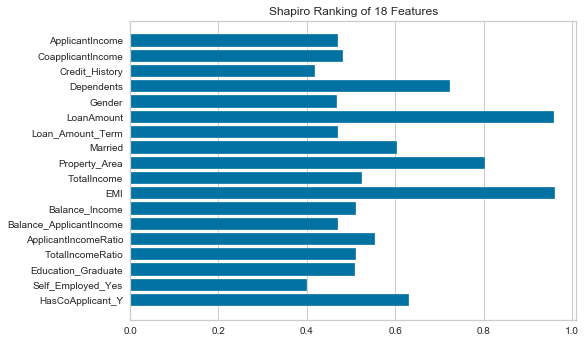

In [17]:
visualizer = Rank1D(features=features, algorithm='shapiro')
visualizer.fit(train_X, train_y)                # Fit the data to the visualizer
visualizer.transform(train_X)             # Transform the data
visualizer.poof()                   # Draw/show/poof the data

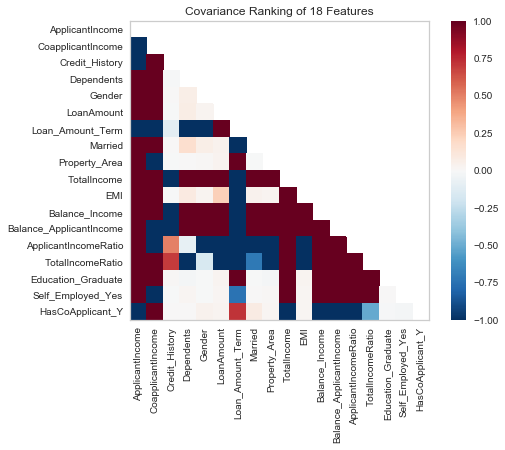

In [18]:
visualizer = Rank2D(features=features, algorithm='covariance')

visualizer.fit(train_X, train_y)                # Fit the data to the visualizer
visualizer.transform(train_X)             # Transform the data
visualizer.poof()  

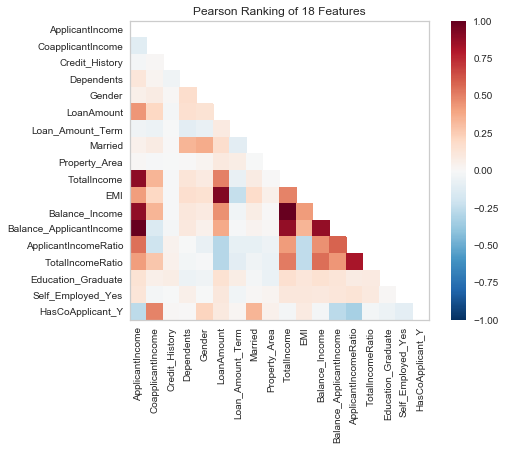

In [19]:
visualizer = Rank2D(features=features, algorithm='pearson')
visualizer.fit(train_X, train_y)                # Fit the data to the visualizer
visualizer.transform(train_X)             # Transform the data
visualizer.poof()

03-Feb-19 17:33:14 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000


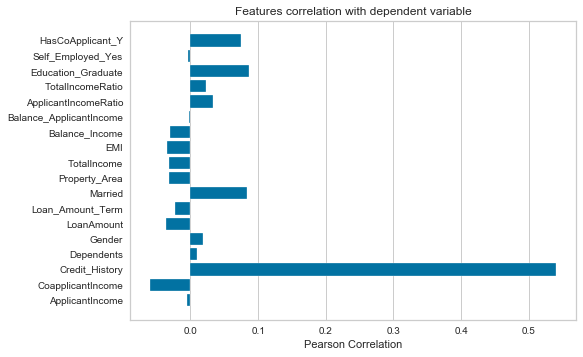

In [20]:
from yellowbrick.target import FeatureCorrelation
fea_corr = FeatureCorrelation(labels=features)
fea_corr.fit(train_X, train_y)                # Fit the data to the visualizer
fea_corr.poof()  